In [176]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn.preprocessing import MinMaxScaler

# Visualize the Data

In [177]:
df = pd.read_csv("./data/features.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Date,Return,Open-Close,Open-Low,Open-High,Close-MA 20D,RSI 14D,Normalized Volume,Realized Volatility 30D,VIX,VIX Move,VIX Open-Close
0,1995-01-03,-0.000348,-0.000218,-0.004377,0.000131,0.007283,0.532690,-0.556965,0.100032,14.25,0.079545,0.011356
1,1995-01-04,0.003485,0.003441,-0.003420,0.003463,0.009975,0.563792,0.273094,0.099786,13.53,-0.050526,-0.024513
2,1995-01-05,-0.000803,-0.000847,-0.002127,0.001237,0.008364,0.554631,0.115542,0.097703,13.50,-0.002217,-0.014599
3,1995-01-06,0.000739,0.000652,-0.001977,0.004583,0.008066,0.561685,0.143239,0.081286,13.13,-0.027407,-0.039503
4,1995-01-09,0.000326,0.000347,-0.002019,0.002388,0.006700,0.564956,-0.229424,0.081226,13.33,0.015232,-0.014782


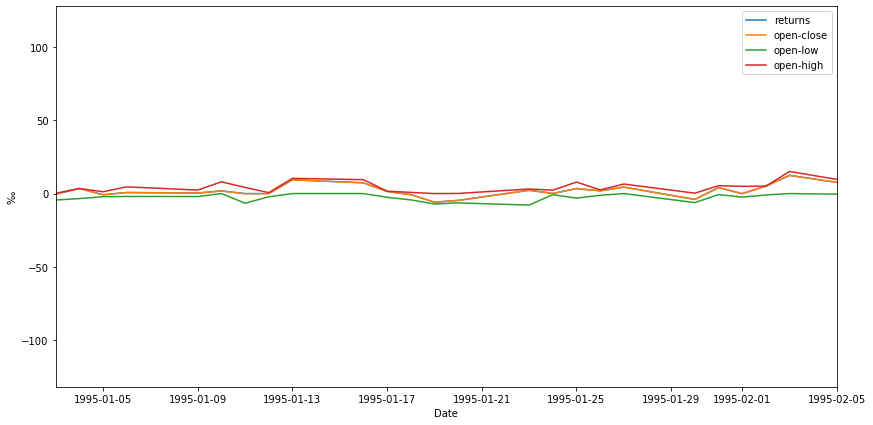

In [178]:
fix, ax = plt.subplots(figsize=(14,7))

ax.plot(df['Date'], df['Return']*1000, label = 'returns')
ax.plot(df['Date'], df['Open-Close']*1000, label = 'open-close')
ax.plot(df['Date'], df['Open-Low']*1000, label = 'open-low')
ax.plot(df['Date'], df['Open-High']*1000, label = 'open-high')

ax.set_xlabel('Date')
ax.set_ylabel('‰')
plt.xlim(pd.to_datetime('1995-01-03'), pd.to_datetime('1995-02-05'))
plt.legend()
plt.show()

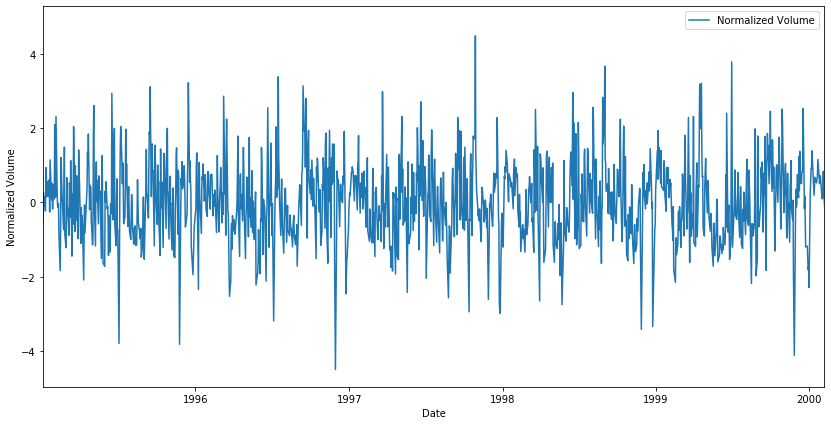

In [179]:
fix, ax = plt.subplots(figsize=(14,7))

ax.plot(df['Date'], df['Normalized Volume'], label = 'Normalized Volume')
ax.set_xlabel('Date')
ax.set_ylabel('Normalized Volume')
plt.xlim(pd.to_datetime('1995-01-03'), pd.to_datetime('2000-02-05'))
plt.legend()
plt.show()

# TimeGAN

In [180]:
def prep_data(data: np.array, window_len, scaler) -> np.array:
    
    """
    Args:
      -  data = np.array
      -  window_len = length of window
      -  scaler = sklearn.preprocessing

    Returns:
      - processed: preprocessed data as python list
    """
    # normalize data
    scaler = scaler.fit(data)
    scaled_data = scaler.transform(data)
    
    # group data into windows of length window_len
    windows = []
    for i in range(len(data) - window_len):
        windows.append(scaled_data[i:i+window_len])
        
    # reorder the data
    idx = np.random.permutation(len(windows))

    processed = []
    for i in range(len(windows)):
        processed.append(windows[idx[i]])
    
    return processed


In [181]:
# define minmax scaler
scaler = MinMaxScaler()

# set index to date
try:
    df = df.set_index('Date').sort_index()
except:
    df = df

# prep data
data = prep_data(df.values, 30, scaler)

# check size
print(len(data), data[0].shape)

6769 (30, 11)


In [182]:
seq_len = 30        # Timesteps
n_seq = 11          # Features

hidden_dim = 24     # Hidden units for generator (GRU & LSTM)

gamma = 1           # discriminator loss

noise_dim = 32      # Used by generator as a starter dimension
dim = 128           # UNUSED
batch_size = 128

learning_rate = 5e-4
beta_1 = 0          # UNUSED
beta_2 = 1          # UNUSED
data_dim = 28       # UNUSED

# batch_size, lr, beta_1, beta_2, noise_dim, data_dim, layers_dim
gan_args = [batch_size, learning_rate, beta_1, beta_2, noise_dim, data_dim, dim]

In [183]:
from ydata_synthetic.synthesizers.timeseries import TimeGAN
# define model
synth = TimeGAN(model_parameters=gan_args, hidden_dim=hidden_dim, seq_len=seq_len, n_seq=n_seq, gamma=1)
synth.train(energy_data, train_steps=500)
synth.save('synth.pkl')

synth_data = synth.sample(len(data))

ModuleNotFoundError: No module named 'ydata_synthetic'

In [ ]:
synth_data = np.array(synth_data)

import pickle as pkl
with open('generated.pkl','wb') as f:
    pkl.dump(synth_data, f)


# LSTM Prediction

Eventually, we might want to preprocess the data (detrend and such). For now, I am implementing a a simple binary forecasting method. I plotted the data above and I don't see much of a trend in the data, since we model returns anyway, but it might be best practice to subtract the running mean or perform similar kind of preprocessing/feature transformation. Also, I'm going to add code to do proper cross validation for time series (sliding window approach). For now I have only implemented a basic train/test split, which I think should be fine for the midterm report. The main focus should be on the data generation, not the forecasting. also only using return to predict the next day's returns for now, i tried with all features, and it wasn't any better.

In [307]:
def train_test_window(data, window_len, split):    
    """
    Passes sliding window of window_len, and splits into train/test
    
    Args:
      -  data = np.array
      -  window_len = length of window
      -  split = training fraction (e.g 0.8)

    """
    # get train size
    train_set_size = int(np.round(split*len(data)))
    
    # sliding window
    windows = []
    for i in range(len(data) - window_len):
        windows.append(data[i:i+window_len])
         
    #get train/test split
    data = np.array(windows)
    train_size = int(np.round(split*len(data)))

    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,0]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,0]

    return x_train, y_train, x_test, y_test
    

In [318]:
df = pd.read_csv("./data/features.csv")
df['Date'] = pd.to_datetime(df['Date'])

try:
    df = df.set_index('Date').sort_index()
except:
    df = df
    
returns = df[['Return']]
scaler = MinMaxScaler()

scaler.fit(returns)
returns_scaled = scaler.transform(returns)
x_train, y_train, x_test, y_test = train_test_window(returns_scaled, 60,0.9)

In [319]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(6119, 59, 1) (6119, 1) (620, 59, 1) (620, 1)


In [320]:
import torch
import torchvision

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [321]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [326]:
input_dim = x_train.shape[2]
hidden_dim = 32
num_layers = 2
output_dim = y_train.shape[1]
num_epochs = 100

In [327]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [328]:
losses = np.zeros(num_epochs)
for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train)
    if t%10==0:
        print("Epoch ", t, "MSE: ", loss.item())
    if t==num_epochs-1:
        last = y_train_pred
    losses[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

Epoch  0 MSE:  0.3858180046081543
Epoch  10 MSE:  0.007193954661488533
Epoch  20 MSE:  0.003914832137525082
Epoch  30 MSE:  0.003615401219576597
Epoch  40 MSE:  0.0026415977627038956
Epoch  50 MSE:  0.002454190282151103
Epoch  60 MSE:  0.0024968318175524473
Epoch  70 MSE:  0.0024457972031086683
Epoch  80 MSE:  0.0024487159680575132
Epoch  90 MSE:  0.002443249337375164


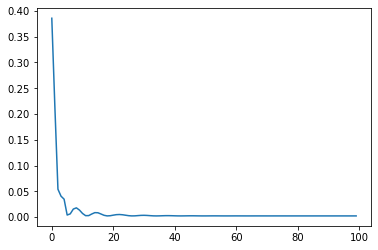

In [329]:
plt.plot(losses)

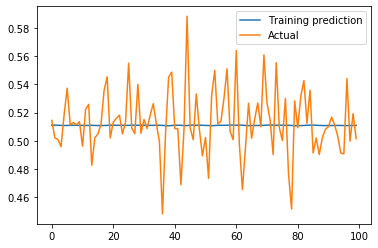

In [330]:
plt.plot(last.detach().numpy()[0:100],label = 'Training prediction')
plt.plot(y_train.numpy()[0:100],label = 'Actual')
plt.legend()
plt.show()

In [331]:
true = scaler.inverse_transform(y_train.numpy())
pred = scaler.inverse_transform(last.detach().numpy())

true = np.where(true>0,1,0)
pred = np.where(pred>0,1,0)

In [332]:
from sklearn.metrics import accuracy_score
print(accuracy_score(true,pred))

0.5378329792449746


# GRU Prediction

In [333]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out


In [334]:
model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [335]:
losses = np.zeros(num_epochs)
for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train)
    if t%10==0:
        print("Epoch ", t, "MSE: ", loss.item())
    if t==num_epochs-1:
        last = y_train_pred
    losses[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

Epoch  0 MSE:  0.35026171803474426
Epoch  10 MSE:  0.005585855338722467
Epoch  20 MSE:  0.007140394300222397
Epoch  30 MSE:  0.003485149471089244
Epoch  40 MSE:  0.0025034325663000345
Epoch  50 MSE:  0.002675833413377404
Epoch  60 MSE:  0.002440953627228737
Epoch  70 MSE:  0.00246985605917871
Epoch  80 MSE:  0.002441086107864976
Epoch  90 MSE:  0.0024397647939622402


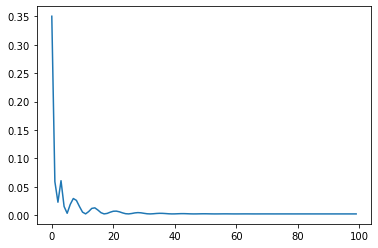

In [338]:
plt.plot(losses)

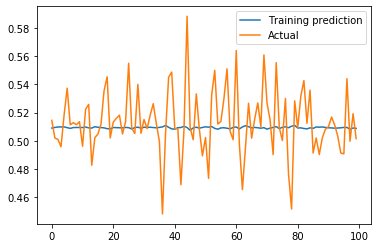

In [336]:
plt.plot(last.detach().numpy()[0:100],label = 'Training prediction')
plt.plot(y_train.numpy()[0:100],label = 'Actual')
plt.legend()
plt.show()

In [337]:
true = scaler.inverse_transform(y_train.numpy())
pred = scaler.inverse_transform(last.detach().numpy())

true = np.where(true>0,1,0)
pred = np.where(pred>0,1,0)

print(accuracy_score(true,pred))

0.5198561856512502
